For this project we have choose Ebay to scrapper and gather data.

--------
## Step - 1
Scrapping

In [ ]:
import csv
import re
import urllib.parse
import urllib.request
from threading import Thread

from bs4 import BeautifulSoup

data = {}
country_dict = {
    'au': '.com.au',
    'at': '.at',
    'be': '.be',
    'ca': '.ca',
    'ch': '.ch',
    'de': '.de',
    'es': '.es',
    'fr': '.fr',
    'hk': '.com.hk',
    'ie': '.ie',
    'it': '.it',
    'my': '.com.my',
    'nl': '.nl',
    'ph': '.ph',
    'pl': '.pl',
    'sg': '.com.sg',
    'uk': '.co.uk',
    'us': '.com',
}
thread_list = []
condition_dict = {
    'all': '',
    'new': '&LH_ItemCondition=1000',
    'opened': '&LH_ItemCondition=1500',
    'refurbished': '&LH_ItemCondition=2500',
    'used': '&LH_ItemCondition=3000'
}

type_dict = {
    'all': '&LH_All=1',
    'auction': '&LH_Auction=1',
    'bin': '&LH_BIN=1',
    'offers': '&LH_BO=1'
}


def items(query, country='us', condition='all', item_type='all'):
    if country not in country_dict:
        raise Exception('Country not supported, please use one of the following: ' + ', '.join(country_dict.keys()))

    if condition not in condition_dict:
        raise Exception('Condition not supported, please use one of the following: ' + ', '.join(condition_dict.keys()))

    if item_type not in type_dict:
        raise Exception('Type not supported, please use one of the following: ' + ', '.join(type_dict.keys()))

    soup = get_html(query, country, condition, item_type, already_sold=False)
    data = parse_items(soup)

    return data


def average(query, country='us', condition='all'):
    if country not in country_dict:
        raise Exception('Country not supported, please use one of the following: ' + ', '.join(country_dict.keys()))

    if condition not in condition_dict:
        raise Exception('Condition not supported, please use one of the following: ' + ', '.join(condition_dict.keys()))

    soup = get_html(query, country, condition, item_type='all', already_sold=True)
    data = parse_prices(soup)

    avg_price = round(__average(data['price_list']), 2)
    avg_shipping = round(__average(data['shipping_list']), 2)

    return {
        'price': avg_price,
        'shipping': avg_shipping,
        'total': round(avg_price + avg_shipping, 2)
    }


def get_html(query, country, condition='', item_type='all', already_sold=True):
    already_sold_string = '&LH_Complete=1&LH_Sold=1' if already_sold else ''

    # Build the URL
    parsed_query = urllib.parse.quote(query).replace('%20', '+')
    url = f'https://www.ebay{country_dict[country]}/sch/i.html?_from=R40&_nkw=' + parsed_query + already_sold_string + \
          condition_dict[condition] + type_dict[item_type]

    # Get the web page HTML
    request = urllib.request.urlopen(url)
    soup = BeautifulSoup(request.read(), 'html.parser')

    return soup


def get_info_single_product(url):
    global data
    item_code = url[url.find('itm') + 4: url.find('?')]
    request = urllib.request.urlopen(url)
    soup = BeautifulSoup(request.read(), 'html.parser')

    seller_name_element = soup.find('h2', class_='d-stores-info-categories__container__info__section__title')
    seller_name = seller_name_element.get_text(strip=True) if seller_name_element else ""

    feedback_pr_elm = soup.find('div', {'class': 'd-stores-info-categories__container__info__section__item'})
    feedback_pr = feedback_pr_elm.get_text(strip=True) if feedback_pr_elm else "0"

    labels = [elm.get_text(strip=True) if elm else "" for elm in
              soup.findAll('div', {'class': 'fdbk-detail-seller-rating__label'})]
    values = [elm.get_text(strip=True) if elm else "0.0" for elm in
              soup.findAll('span', {'class': 'fdbk-detail-seller-rating__value'})]

    item_primary_price_elm = soup.find('div', {'class': 'x-price-primary'})
    item_primary_price = item_primary_price_elm.get_text(strip=True) if item_primary_price_elm else "0"

    item_approx_price_elm = soup.find('div', {'class': 'x-price-approx'})
    item_approx_price = item_approx_price_elm.get_text(strip=True) if item_approx_price_elm else "0"

    comment_elm = soup.findAll('div', {'class': 'fdbk-container__details__comment'})
    comment = "&".join(i.get_text(strip=True) for i in comment_elm) if comment_elm else "0"

    item_data = {
        'seller_name': seller_name,
        'feedback_pr': feedback_pr,
        'item_primary_price': ".".join(re.findall(r'[0-9]+', item_primary_price)),
        'item_approx_price': ".".join(re.findall(r'[0-9]+', item_approx_price, )),
        'comment': comment,
    }
    item_data.update({i: j for i, j in zip(labels, values)})
    data.setdefault(item_code, {}).update(item_data)


def parse_items(soup):
    global data
    raw_items = soup.find_all('div', {'class': 's-item__info clearfix'})

    for item in raw_items[1:]:

        # Get item data
        title = item.find(class_="s-item__title").find('span').get_text(strip=True)

        price = parse_raw_price(item.find('span', {'class': 's-item__price'}).get_text(strip=True))

        try:
            shipping = parse_raw_price(
                item.find('span', {'class': 's-item__shipping s-item__logisticsCost'}).find('span', {
                    'class': 'ITALIC'}).get_text(strip=True))
        except:
            shipping = 0

        try:
            time_left = item.find(class_="s-item__time-left").get_text(strip=True)
        except:
            time_left = ""

        try:
            time_end = item.find(class_="s-item__time-end").get_text(strip=True)
        except:
            time_end = ""

        try:
            bid_count = int(
                "".join(filter(str.isdigit, item.find(class_="s-item__bids s-item__bidCount").get_text(strip=True))))
        except:
            bid_count = 0

        try:
            review_count = int("".join(
                filter(str.isdigit, item.find(class_="s-item__reviews-count").find('span').get_text(strip=True))))
        except:
            review_count = 0

        url = item.find('a')['href']

        item_data = {
            'title': title,
            'price': price,
            'shipping': shipping,
            'time_left': time_left,
            'time_end': time_end,
            'bid_count': bid_count,
            'review_count': review_count,
            'url': url
        }

        data[url[url.find('itm') + 4: url.find('?')]] = item_data

        thread_list.append(Thread(target=get_info_single_product, args=(url,)))

    # Remove item with prices too high or too low
    # price_list = [item['price'] for item in data.values()]
    # parsed_price_list = st_dev_parse(price_list)
    # data = [item for item in data if item['price'] in parsed_price_list]
    #
    # return sorted(data, key=lambda dic: dic['price'] + dic['shipping'])
    return data


def parse_prices(soup):
    # Get item prices
    raw_price_list = [price.get_text(strip=True) for price in soup.find_all(class_="s-item__price")]
    price_list = [price for price in map(lambda raw_price: parse_raw_price(raw_price), raw_price_list) if price]

    # Get shipping prices
    raw_shipping_list = [item.get_text(strip=True) for item in
                         soup.find_all(class_="s-item__shipping s-item__logisticsCost")]
    shipping_list = map(lambda raw_price: parse_raw_price(raw_price), raw_shipping_list)
    shipping_list = [0 if price is None else price for price in shipping_list]

    # Remove prices too high or too low
    price_list = st_dev_parse(price_list)
    shipping_list = st_dev_parse(shipping_list)

    data = {
        'price_list': price_list,
        'shipping_list': shipping_list
    }
    return data


def parse_raw_price(string):
    parsed_price = re.search(r'(\d+(.\d+)?)', string.replace(',', '.'))
    if parsed_price:
        return float(parsed_price.group())
    return None


def __average(number_list):
    if len(list(number_list)) == 0: return 0
    return sum(number_list) / len(list(number_list))


def st_dev(number_list):
    if len(list(number_list)) == 0: return 0

    nominator = sum(map(lambda x: (x - sum(number_list) / len(number_list)) ** 2, number_list))
    st_deviation = (nominator / (len(number_list) - 1)) ** 0.5

    return st_deviation


def st_dev_parse(number_list):
    avg = __average(number_list)
    st_deviation = st_dev(number_list)

    # Remove prices too high or too low; Accept Between -1 StDev to +1 StDev
    number_list = [no for no in number_list if (avg + st_deviation > no > avg - st_deviation)]

    return number_list


# Unique or Vintage Items: These items are often one-off or secondhand designer pieces that attract a lot of
# attention and bids due to their uniqueness and rarity Health & Beauty: Products such as vitamins & dietary
# supplements, skincare products, perfume, hair straighteners, and hair dryers are among the best-selling items in
# this category Clothing: Specifically, women's jeans, men's t-shirts, and men's hats are among the top-selling items
# in the clothing category Electronics: Items like cables, computers, and mobile accessories are popular in this
# category Toys: This category is frequently bought, making it a popular choice for sellers Pet Supplies: This
# category is also among the most frequently bought items on eBay

product_list = [
    # 'vitamins and dietary supplements'
    # 'skincare products',
    # 'perfume',
    # 'hair straighteners',
    # 'hair dryers',
    # 'Electronics',
    # 'cables',
    # 'computers',
    # 'mobile accessories',
    # 'Toys',
    # 'Apple',
    # 'scanners',
    # 'Shoes',
    # 'Adidas',
    # 'Nike',
    # 'furniture',
    # 'Afghans',
    # 'Throw Blankets',
    # 'Afghans and Throw Blankets',
    # 'Pet Supplies',
    # 'Bookends',
    # 'Jewelry',
    # 'Watches',
    # 'Necklaces',
    # 'Pendants',
    # 'Wristwatch Bands',
    # 'Wristwatches',
    # 'sports memorabilia',
    # 'Historical Artifacts',
    # 'Automotive Parts',
    # 'Fashion',
    # 'Motors',
    # 'Collectibles',
    # 'Musical Instruments and Gear',
    # 'Motors',
]

main_threads = []
for product in product_list:
    # main_threads.append(Thread(target=items, args=(product, 'ca', 'all', 'offers')))
    items(query=product, country='ca', condition='all', item_type='offers')

for i in main_threads:
    i.start()

for i in main_threads:
    i.join()

for i in thread_list:
    i.start()

for i in thread_list:
    i.join()

# Specify the CSV file path
csv_file = 'output.csv'

# Write the dictionary to a CSV file
with open(csv_file, 'a', newline='') as csvfile:
    field_names = ['url', 'item_approx_price', 'Accurate description', 'price', 'time_left', 'seller_name',
                   'Communication', 'time_end', 'Shipping speed', 'title', 'shipping', 'bid_count', 'feedback_pr',
                   'item_primary_price', 'review_count', 'Reasonable shipping cost', 'item_no', 'comment']
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()  # Write the header row with field names
    for i, row in data.items():
        row['item_no'] = i
        writer.writerow(row)


-----
## Step - 2
proceed with initial steps of data wrangling and properly name/label/explain the activities in this (and all other) steps. Use the data you provided in step 1 and apply data wrangling steps including but not limited to data cleaning, formatting and structuring, validating etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jaydeep32/datasets/main/final_ebay_products.csv')
# df = pd.read_csv('https://mylambton-my.sharepoint.com/:x:/g/personal/c0892415_mylambton_ca/EQTcz8oGK_5LhlFrfnOKzmEBEhtH8rEqAHTGlQX-enVgow?e=z3FjH9')

### Dataset Description

This dataset contains information about eBay listings, including various attributes related to the listings and sellers. The data can be used for analysis, including clustering to identify patterns and trends within the eBay marketplace.

### Columns

1. `url`: The URL of the eBay listing.
2. `item_approx_price`: The approximate price of the item.
3. `Accurate description`: A rating of how accurate the description of the item is (float out of 5).
4. `price`: The listed price of the item.
5. `time_left`: The time remaining for the listing to end.
6. `seller_name`: The name of the seller.
7. `Communication`: A rating of the seller's communication (float out of 5).
8. `time_end`: The end time of the listing.
9. `Shipping speed`: A rating of the speed of shipping (float out of 5).
10. `title`: The title of the item listing.
11. `shipping`: The cost of shipping.
12. `bid_count`: The count of bids made on the item.
13. `feedback_pr`: The seller's feedback percentage (should be a percentage out of 100).
14. `item_primary_price`: The primary price of the item.
15. `review_count`: The count of reviews received for the item.
16. `Reasonable shipping cost`: A rating of the reasonability of the shipping cost (float out of 5).
17. `item_no`: The item number.
18. `comment`: Any additional comments related to the listing.

### Clustering

Based on the dataset, clustering analysis can be performed using the following columns:

- `item_approx_price`: The approximate price of the item.
- `Accurate description`: A rating of how accurate the description of the item is (float out of 5).
- `Communication`: A rating of the seller's communication (float out of 5).
- `Shipping speed`: A rating of the speed of shipping (float out of 5).
- `feedback_pr`: The seller's feedback percentage (should be a percentage out of 100).
- `item_primary_price`: The primary price of the item.
- `review_count`: The count of reviews received for the item.
- `Reasonable shipping cost`: A rating of the reasonability of the shipping cost (float out of 5).

By using these columns, you can analyze the patterns and relationships between various attributes and gain valuable insights into the eBay marketplace dynamics.


In [3]:
df.head(2)

,url,item_approx_price,Accurate description,price,time_left,seller_name,Communication,time_end,Shipping speed,title,shipping,bid_count,feedback_pr,item_primary_price,review_count,Reasonable shipping cost,item_no,comment
0,https://www.ebay.ca/itm/404538144791?hash=item...,62.36,5.0,54.38,NaN,cheaptabsluvr,5.0,NaN,5.0,"Tablet Vortex T10, 10.1Inch Display 4GB RAM & ...",68.99,0,100%Positive Feedback,39.99,0,4.8,404538144791,NaN
1,https://www.ebay.ca/itm/145220746068?hash=item...,93.66,4.9,93.66,NaN,BLAVOR,5.0,NaN,5.0,"Maxwest Astro 10R Android LTE Tablet, 10.1 Cur...",33.30,0,99.5%Positive Feedback,68.88,0,4.9,145220746068,NaN


In [4]:
df.dtypes

url                          object
item_approx_price            object
Accurate description         object
price                       float64
time_left                    object
seller_name                  object
Communication                object
time_end                     object
Shipping speed               object
title                        object
shipping                    float64
bid_count                     int64
feedback_pr                  object
item_primary_price           object
review_count                  int64
Reasonable shipping cost     object
item_no                       int64
comment                      object
dtype: object

### Explanation of Data Preprocessing Step
-----

- As you can see data types of each column mostly all columns are not in proper formatting so that first we need to perform respected processing and then we can perform clustering.

-----

- In the data preprocessing step for the `feedback_pr` column, I aimed to extract numerical values to facilitate further analysis.
- The `feedback_pr` column initially contained text along with numerical values, making it challenging to perform quantitative analysis directly.
- To address this issue, we utilized the `str.extract` method in Pandas, which enabled the extraction of numerical values based on the provided pattern.

In [5]:
# Extracting numerical values from the 'feedback_pr' column and setting 0 if the pattern does not match
df['feedback_pr'] = df['feedback_pr'].str.extract('(\d+\.\d+)', expand=False).fillna(0)

------

- This decision was made to ensure that the dataset remains concise, relevant, and aligned with the objectives of the eBay clustering project. By removing these columns, the focus was directed toward the key attributes that are more likely to contribute to the clustering process, thus enabling a more effective and efficient analysis of the data.

- Additionally, the removal of these columns aids in reducing the dimensionality of the dataset, which can be particularly advantageous when working with large datasets, as it can help improve the computational performance and reduce the risk of overfitting in subsequent modeling or analysis tasks.

- One more reason we have is that when we scape this data from Ebay there are no any specific offer goin on for these products so that most of the value related to `time_left` and `time_end` columns are empty anyway.

- `price` and `shipping` column also has the identical value as `item_approx_price` and `item_primary_price`

- `url` this field also has no purpose now since this url only reveal unique product id on ebay which we have already extracted it and added as index value in `df` DataFrame.

- So ultimatly we have decided to remove all 4 of these columns.


In [6]:
# Drop unecessry columns
df.drop(columns=['price', 'shipping', 'time_left', 'time_end', 'url'], inplace=True)

-----
- The result of this operation indicated that out of the total **5806** rows in the DataFrame, **5806** rows contained a `0` value in the `bid_count` column.
- This finding suggested that the `bid_count` column might not provide significant variability or insights for the clustering analysis, given the prevalence of `0` values.
- Consequently, it was decided to drop the `bid_count` column from the DataFrame.

In [7]:
# Count the number of 0 values in the 'bid_count' column and compare it wil total df length.
count_of_zeros = (df['bid_count'] == 0).sum()
print(count_of_zeros, df.shape)

5806 (5806, 13)


In [8]:
# drop bid_count too baucause 5806 rows has '0' value
df.drop(columns=['bid_count'], inplace=True)

In [9]:
df.head(2)

,item_approx_price,Accurate description,seller_name,Communication,Shipping speed,title,feedback_pr,item_primary_price,review_count,Reasonable shipping cost,item_no,comment
0,62.36,5.0,cheaptabsluvr,5.0,5.0,"Tablet Vortex T10, 10.1Inch Display 4GB RAM & ...",0,39.99,0,4.8,404538144791,NaN
1,93.66,4.9,BLAVOR,5.0,5.0,"Maxwest Astro 10R Android LTE Tablet, 10.1 Cur...",99.5,68.88,0,4.9,145220746068,NaN


-----
- The provided code is focused on renaming specific columns within the DataFrame to establish a standardized format for improved consistency and ease of analysis.
- The dictionary `column_name_mapping` was created to map the original column names to their respective standardized format.

The original column names were as follows:

- 'Accurate description'
- 'Communication'
- 'Shipping speed'
- 'Reasonable shipping cost'

These names were mapped to the standardized format as follows:

- 'accurate_description'
- 'communication'
- 'shipping_speed'
- 'reasonable_shipping_cost'

By utilizing the `rename` method in Pandas, the columns were renamed according to the mapping specified in the `column_name_mapping` dictionary. This process aimed to facilitate a more streamlined and consistent approach to data analysis, ensuring that the DataFrame columns are easily identifiable and accessible throughout the project.


In [10]:
column_name_mapping = {
    'Accurate description': 'accurate_description',
    'Communication': 'communication',
    'Shipping speed': 'shipping_speed',
    'Reasonable shipping cost': 'reasonable_shipping_cost'
}

# Rename the columns to proper format
df.rename(columns=column_name_mapping, inplace=True)

------
- `non_convertible_flt_values` this function is pretty handy in finding un relevant values in each of this columns which should be in float dtype.
- This function will return all unique value for that column which can not be converted.

In [11]:
def non_convertible_flt_values(col_name, df):
    """
    Identifies non-convertible values within the specified DataFrame column.

    Parameters:
    col_name (str): The name of the column to be analyzed.
    df (pandas.DataFrame): The DataFrame containing the data.

    Returns:
    list: A list of unique non-convertible values found in the specified column.
    """
    # Initialize an empty list to store non-convertible values
    non_convertible_values_list = []  
    # Iterate through each value in the specified column
    for value in df[col_name]:  
        try:
            # Attempt to convert the value to a float
            float(value)  
        except (ValueError, TypeError):
            non_convertible_values_list.append(value)
    # Extract unique non-convertible values
    unique_non_convertible_values = list(set(non_convertible_values_list))  
    # Return the list of unique non-convertible values
    return unique_non_convertible_values  

# print(non_convertible_flt_values("item_primary_price", df))
# print(non_convertible_flt_values("item_approx_price", df))

In [12]:
float_col_names = ['accurate_description','communication','shipping_speed', 'reasonable_shipping_cost', 'item_primary_price', 'item_approx_price', 'feedback_pr']

for col in float_col_names:
    print(f" {col} ".center(50, '-'))
    print(f"Weird values: {non_convertible_flt_values(col, df)}")
    

-------------- accurate_description --------------
Weird values: ['--']
----------------- communication ------------------
Weird values: ['--']
----------------- shipping_speed -----------------
Weird values: ['--']
------------ reasonable_shipping_cost ------------
Weird values: ['--']
--------------- item_primary_price ---------------
Weird values: ['2.399.00', '2.112.50', '1.025.00', '3.727.77', '1.649.99', '1.550.00', '3.499.44', '1.000.00', '1.849.00', '1.002.99', '1.399.00', '2.499.99', '1.750.00', '1.150.00', '1.779.40', '1.977.28', '1.499.99', '1.895.00', '1.234.05', '1.695.00', '1.250.00', '1.570.19', '1.500.00', '5.000.00', '1.599.00', '2.200.00', '3.061.80', '5.499.99', '1.800.00', '1.486.00', '30.000.00', '1.060.00', '1.300.00', '1.698.00', '1.400.00', '2.099.00', '2.199.99', '9.026.12', '1.369.99', '1.199.51', '1.139.00', '1.399.99', '1.049.00', '1.499.00', '2.464.37', '1.987.62', '1.650.00', '2.339.56', '2.950.00', '1.341.64', '1.699.99', '1.200.00', '1.099.00', '2.399.99

-----
- When you analys the above cell output you will see that each column same some unwanted values.
- So now in following cells we will go though each signle one of these values and format them to be available in float.
- The following 4 columns has fixed number from 0 - 5.
    - 'accurate_description'
    - 'communication'
    - 'shipping_speed'
    - 'reasonable_shipping_cost 
- So in any case if value is not appropriate then we can change that value with 0. By doing so we will consider this row and seller as if he did not perform well and got 0 reviews. We can consoder this way of handling this wrong values because when we look at the ebay website for each of this product the selling was 0 as well as seller has no proper name and relevant information. So it is safer to assume that this is not regular seller.

- Check this item_no **166366589055** has weird price value.
- When we were manually looking at the dataset we found out that in both prices column `item_primary_price` and `item_approx_price` we had some value where thousant seperator was `(.)` instead of `(,)`.

In [13]:
df[df.item_no == 166366589055]

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment
2708,1.364.58,5.0,DealsGuru1,5.0,5.0,Seiko Prospex Alpinist 39.5 MM Automatic GMT B...,99.6,999.00,0,5.0,166366589055,NaN
5092,1.288.32,5.0,DealsGuru1,5.0,5.0,Seiko Prospex Alpinist 39.5 MM Automatic GMT B...,99.5,945.00,0,5.0,166366589055,"Good seller, fast shipment, perfect product&Aw..."


In [14]:
df[df.accurate_description == '--'].head(1)

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment
306,956.06,--,circuitsupply,--,5.0,HP Victus 15.6” Gaming Laptop R7-5800H/ 16GB R...,94.1,700.00,0,5.0,266447836176,NaN


- `remove_thousand_separator` this function will try to convert normal value to float value.
- if there is some error which means we have wrong value then we will return `0` and save that in respected column.

In [15]:
def remove_thousand_separator(value):
    """
    Removes thousand separators from the given value and converts it to a float if possible.

    Parameters:
    value (str or numeric): The value from which to remove thousand separators.

    Returns:
    float: The value with removed thousand separators and converted to a float, if applicable.
          0 if the value cannot be converted.

    Raises:
    ValueError: If the value is not numeric or a string representation of a numeric value.
    """

    # Convert the value to a string
    value_str = str(value)

    if value_str.lower() == 'nan':
        return 0
    
    # Split the value by decimal points
    parts = value_str.split('.')
    
    try:
        # Check if there are exactly two parts (two decimal points)
        if len(parts) == 3:
            # Concatenate the parts to create a corrected value
            corrected_value = ''.join(parts[:-1]) + '.' + parts[-1]
            # Convert the corrected value to float
            return float(corrected_value)
        else:
            # For values with one or zero decimal points, return as is
            return float(value)  # If you want it to remain as a string, remove the float conversion.
    except (ValueError, TypeError):
        # Return 0 if the value cannot be converted
        return 0

# Apply the conversion function to the 'item_approx_price' column
# df['item_approx_price'] = df['item_approx_price'].apply(remove_thousand_separator)

# Apply the conversion function to the 'item_primary_price' column



In [16]:
for col in float_col_names:
    df[col] = df[col].apply(remove_thousand_separator)

In [17]:
# Result after cleaning the data
df[df.item_no == 166366589055]

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment
2708,1364.58,5.0,DealsGuru1,5.0,5.0,Seiko Prospex Alpinist 39.5 MM Automatic GMT B...,99.6,999.0,0,5.0,166366589055,NaN
5092,1288.32,5.0,DealsGuru1,5.0,5.0,Seiko Prospex Alpinist 39.5 MM Automatic GMT B...,99.5,945.0,0,5.0,166366589055,"Good seller, fast shipment, perfect product&Aw..."


In [18]:
df[df.accurate_description == '--'].head(1)

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment


In [19]:
df.dtypes

item_approx_price           float64
accurate_description        float64
seller_name                  object
communication               float64
shipping_speed              float64
title                        object
feedback_pr                 float64
item_primary_price          float64
review_count                  int64
reasonable_shipping_cost    float64
item_no                       int64
comment                      object
dtype: object

In [20]:
df.isna().sum()

item_approx_price              0
accurate_description           0
seller_name                   47
communication                  0
shipping_speed                 0
title                          0
feedback_pr                    0
item_primary_price             0
review_count                   0
reasonable_shipping_cost       0
item_no                        0
comment                     3455
dtype: int64

- As we can see now we only have `seller_name` missing and `comment`.
- For `comment` we will ignore this missing value.
- For `seller_name` those records we actually have missing value in ebay itself.
- we have finally decided to remove those *47* records which has null `seller_name` because our ultimate goal is to cluster the seller based on rattings and find top seller and average one.

In [21]:
df.dropna(inplace=True)

-----
## Step - 3
use proper plotting methods to demonstrate the distribution of various attributed (columns) in the data.

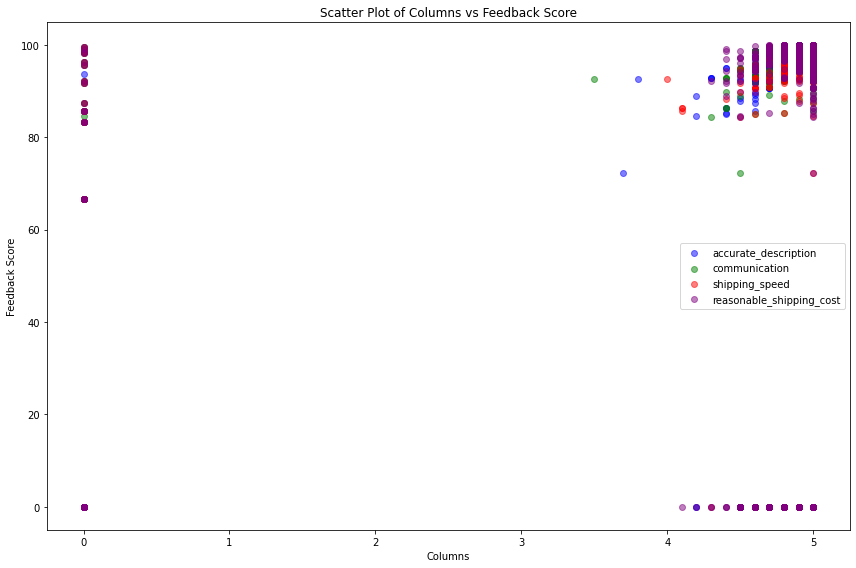

In [22]:
columns = ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

plt.figure(figsize=(12, 8))

for i, col in enumerate(columns):
    plt.scatter(df[col], df['feedback_pr'], color=colors[i], alpha=0.5, label=col)

plt.title('Scatter Plot of Columns vs Feedback Score')
plt.xlabel('Columns')
plt.ylabel('Feedback Score')
plt.legend()
plt.tight_layout()
plt.show()


From the scatter plot, it becomes evident that the columns ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost'] have values ranging from 0 to 5, while the 'feedback_pr' column has values between 0 and 100.

Through visualization, it is apparent that:
- When all four of these columns have values around 5, the 'feedback_pr' tends to increase, indicating that sellers are more likely to receive positive feedback on their products from customers.
- Conversely, if all four columns have values closer to 0, the 'feedback_pr' score is also closer to 0, suggesting that the seller may not receive any feedback from customers at all.
- In cases where only some of these four columns have values closer to 0 and others have values closer to 5, there is still a tendency for the 'feedback_pr' to be higher.


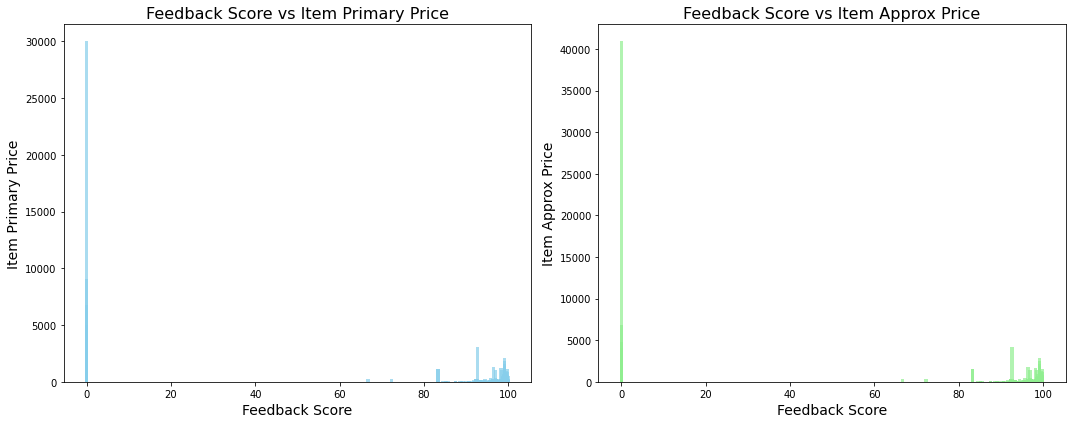

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].bar(df['feedback_pr'], df['item_primary_price'], color='skyblue', alpha=0.7)
ax[0].set_xlabel('Feedback Score', fontsize=14)
ax[0].set_ylabel('Item Primary Price', fontsize=14)
ax[0].set_title('Feedback Score vs Item Primary Price', fontsize=16)

ax[1].bar(df['feedback_pr'], df['item_approx_price'], color='lightgreen', alpha=0.7)
ax[1].set_xlabel('Feedback Score', fontsize=14)
ax[1].set_ylabel('Item Approx Price', fontsize=14)
ax[1].set_title('Feedback Score vs Item Approx Price', fontsize=16)

plt.tight_layout()
plt.show()


- The bar chart comparison highlights a clear correlation between item prices and customer feedback scores.
- Higher-priced items generally yield lower feedback scores, while more affordable items tend to receive higher feedback scores.
- This emphasizes the critical role of pricing strategies in shaping customer satisfaction and underscores the importance of balancing prices with effective feedback management.



-----
## Step - 4
pandas profiling 

In [24]:
# import sys
# !{sys.executable} -m pip install pandas-profiling
# from pandas_profiling import ProfileReport
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

In [25]:

# prof

-------
## Step 5
use proper encoding methods and create new numerical columns that represent the categorical column in the original data (and/or vice versa)


- In this dataset we are not dealing with any type of string categorical features. When we scrapped the data we alredy have number data for categorical features as well.
- we also have one column called `comment` where we have stored comments for each seller for that specific product they are selling
- each comment in this column is seperated with *&* sign. These comments also contain lot of emojis and special characters that we need to handle as well.
- So now we will add new feature called `no_of_comments` based on comments we found for each product.
- Later we will try to do sentiment analysis on these comments and try ro provide score for it as well

In [26]:
import re

def clean_comments(row):
    """
    Cleans the comments in the 'comment' column by removing special characters and emojis.

    Parameters:
    row (Series): A row of the DataFrame.

    Returns:
    str: The cleaned comments without special characters and emojis.
    """
    if pd.isna(row['comment']):
        return ''
    else:
        comment = row['comment']
        # Removing special characters and emojis
        cleaned_comment = re.sub(r'[^&\w\s,]', '', comment)
        return cleaned_comment

# Apply the function to clean the 'comment' column
df['comment'] = df.apply(clean_comments, axis=1)


In [27]:
def count_comments(row):
    """
    Counts the number of comments in the 'comment' column for each row in the DataFrame.

    Parameters:
    row (Series): A row of the DataFrame.

    Returns:
    int: The number of comments found in the 'comment' column for the specific row.
    """
    if pd.isna(row['comment']) or not row['comment']:
        return 0
    else:
        comments = row['comment'].split('&')  # Split the comments by the '&' sign
        return len(comments)

# Apply the function to create the 'no_of_comments' column
df['no_of_comments'] = df.apply(count_comments, axis=1)


In [28]:
df.head(5)

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment,no_of_comments
3451,26.17,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - Muscle Buil...,98.3,19.16,0,5.0,334998922302,arrived on time&Excellent&Never received the p...,4
3452,26.17,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - MALE VIRILI...,98.3,19.16,0,5.0,333636551366,Excellent&Never received the product nor commu...,3
3453,25.98,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - GARCINIA CA...,98.3,19.02,0,5.0,334895188794,Excellent&Never received the product nor commu...,3
3454,30.19,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - CREATINE PO...,98.3,22.10,0,5.0,335055451413,Excellent&Never received the product nor commu...,3
3455,70.70,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - ELK VELVET ...,98.3,51.76,0,5.0,335055439038,Excellent&Never received the product nor commu...,3


----
## Step 6
use proper techniques (boxplots AND IQR) to identify the outliers on each column (attribute) and explain your approach/results.

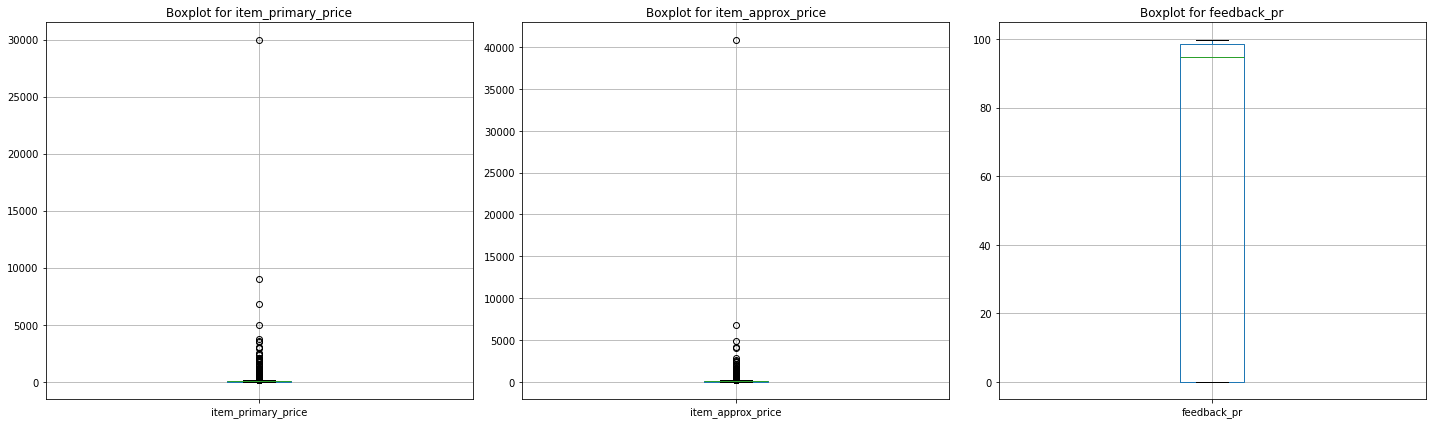

Outliers in item_primary_price: 94
Outliers in item_approx_price: 79
Outliers in feedback_pr: 0


In [29]:
%matplotlib inline

columns_to_check = ['item_primary_price', 'item_approx_price', 'feedback_pr']

# Create subplots to display charts side by side
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_check), figsize=(20, 6))
for i, column in enumerate(columns_to_check):
    df.boxplot(column=[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

plt.tight_layout()
plt.show()


# Identify outliers using IQR
for column in columns_to_check:
    q1 = df[column].quantile(0.10)
    q3 = df[column].quantile(0.90)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Outliers in {column}: {outliers[column].count()}')



-----
## Step 7

use all the following techniques to address the outliers and explain/discuss the differences in the outcome of each of the methods
- Quantile-based Flooring and Capping
- Trimming
- Log Transformation

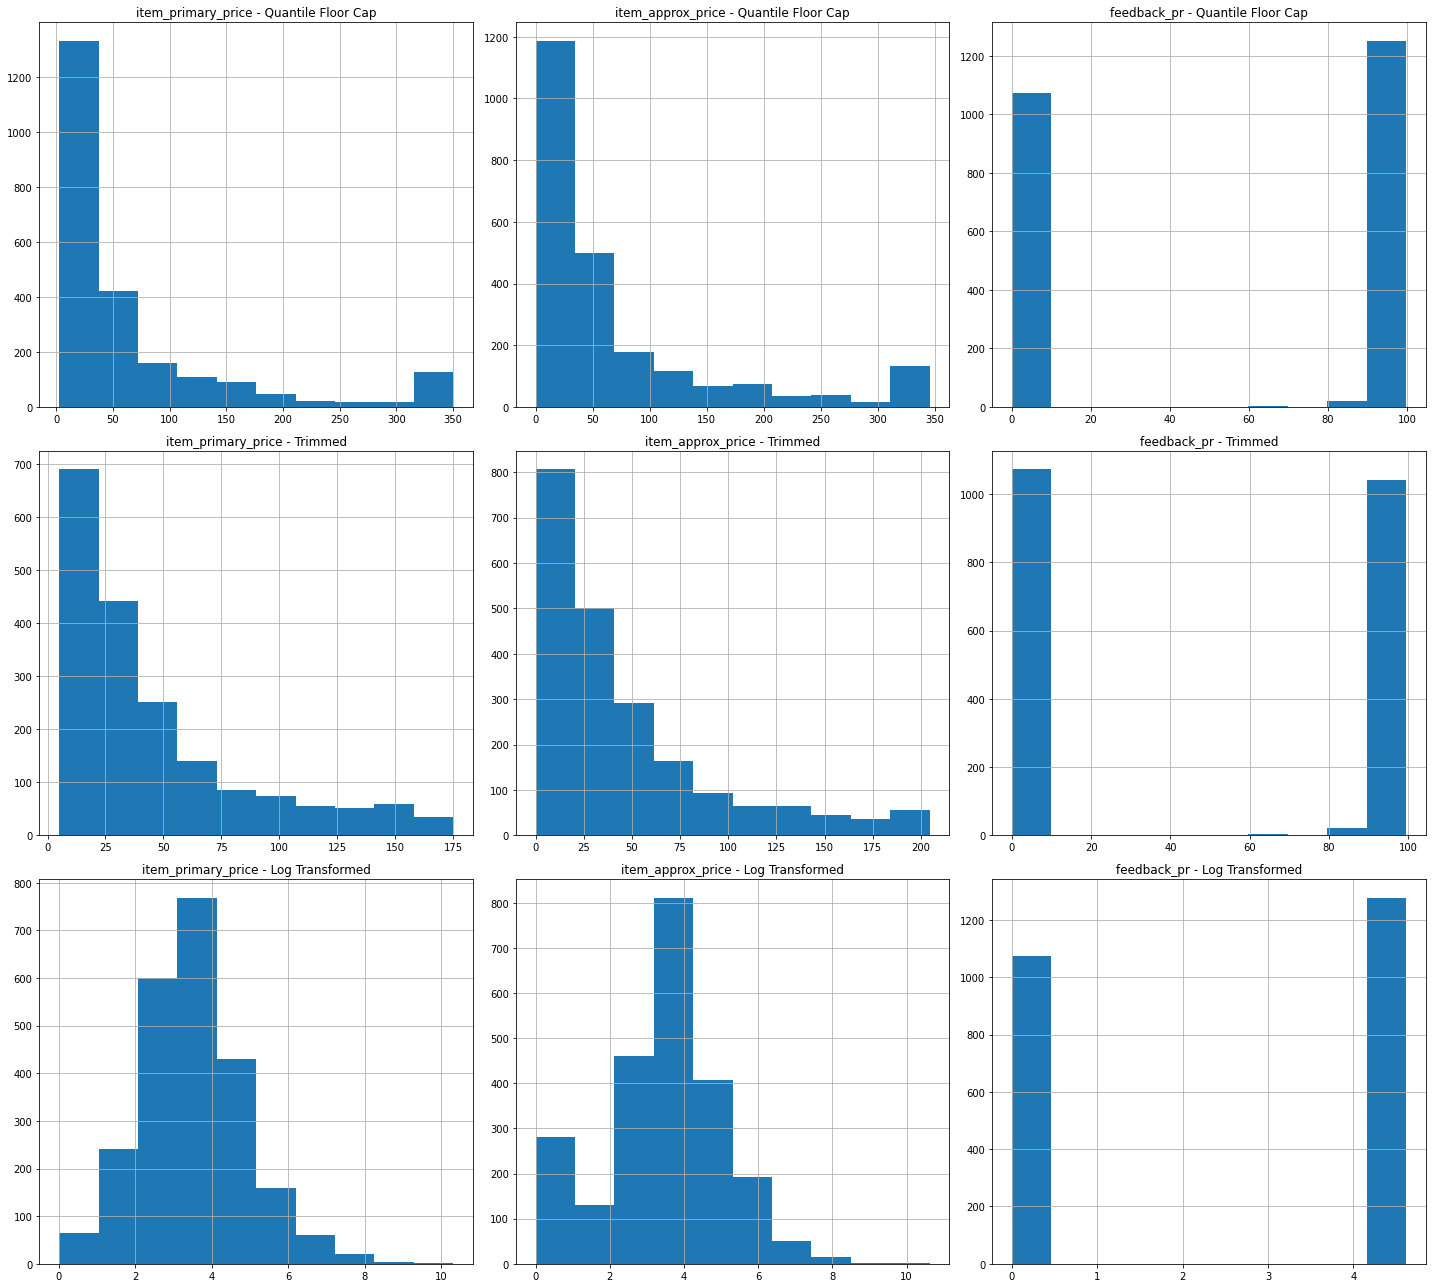

In [30]:
# Create a new DataFrame to store the transformed values
transformed_df = pd.DataFrame()

# Quantile-based Flooring and Capping
def quantile_floor_cap(series, lower_percentile=0.05, upper_percentile=0.95):
    """
    Apply quantile-based flooring and capping to the series.

    Parameters:
    series (pandas.Series): Input data series
    lower_percentile (float): Lower percentile for flooring (default: 0.05)
    upper_percentile (float): Upper percentile for capping (default: 0.95)

    Returns:
    pandas.Series: Transformed data series
    """
    lower_cap = series.quantile(lower_percentile)
    upper_cap = series.quantile(upper_percentile)
    series = series.clip(lower=lower_cap, upper=upper_cap)
    return series

# Trimming
def trim_data(series, trim_value=0.1):
    """
    Trim the data series based on the given trim value.

    Parameters:
    series (pandas.Series): Input data series
    trim_value (float): Value for trimming (default: 0.1)

    Returns:
    pandas.Series: Trimmed data series
    """
    lower_limit = series.quantile(trim_value)
    upper_limit = series.quantile(1 - trim_value)
    series = series[(series >= lower_limit) & (series <= upper_limit)]
    return series

# Log Transformation
def log_transform(series):
    """
    Apply log transformation to the series.

    Parameters:
    series (pandas.Series): Input data series

    Returns:
    pandas.Series: Log-transformed data series
    """
    series = np.log1p(series)
    return series

# Apply the techniques and store results in the new DataFrame
for column in columns_to_check:
    # Copy the original column data to new variables for each technique
    transformed_df[f'{column}_quantile_floor_cap'] = quantile_floor_cap(df[column])
    transformed_df[f'{column}_trimmed'] = trim_data(df[column])
    transformed_df[f'{column}_log_transformed'] = log_transform(df[column])

# Display the results
fig, axes = plt.subplots(nrows=3, ncols=len(columns_to_check), figsize=(20, 18))

for i, column in enumerate(columns_to_check):
    transformed_df[f'{column}_quantile_floor_cap'].hist(ax=axes[0, i])
    axes[0, i].set_title(f'{column} - Quantile Floor Cap')

    transformed_df[f'{column}_trimmed'].hist(ax=axes[1, i])
    axes[1, i].set_title(f'{column} - Trimmed')

    transformed_df[f'{column}_log_transformed'].hist(ax=axes[2, i])
    axes[2, i].set_title(f'{column} - Log Transformed')

plt.tight_layout()
plt.show()


- From the above hist distribution of price columns we can clearly see that in our case we can use **Log Transformation** because with that we can achive proper distribution.
- With **Quantile-based Flooring and Capping**  and **Trimming** we are getting right skewed distribution where as in other method we are kind of getting normal distribution.
- So we think it would be better if we use the 3rd **Log Transformation** method.

In [31]:
for column in columns_to_check:
    df[column] = log_transform(df[column])

In [32]:
df.head()

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment,no_of_comments
3451,3.302113,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - Muscle Buil...,4.598146,3.003700,0,5.0,334998922302,arrived on time&Excellent&Never received the p...,4
3452,3.302113,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - MALE VIRILI...,4.598146,3.003700,0,5.0,333636551366,Excellent&Never received the product nor commu...,3
3453,3.295096,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - GARCINIA CA...,4.598146,2.996732,0,5.0,334895188794,Excellent&Never received the product nor commu...,3
3454,3.440098,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - CREATINE PO...,4.598146,3.139833,0,5.0,335055451413,Excellent&Never received the product nor commu...,3
3455,4.272491,4.9,health-solution-prime,5.0,4.9,Vitamins And Dietary Supplements - ELK VELVET ...,4.598146,3.965753,0,5.0,335055439038,Excellent&Never received the product nor commu...,3


----
## Step 8
Use the unsupervised learning method of your choice (e.g: K-Means ) on the data you have for this assignment and discuss the outcomes. (at least 2 methods to be used and discussed)

### Feature Selection and Clustering Approach

#### Principal Component Analysis (PCA)

- I first applied PCA to the dataset to determine the optimal number of principal components.
- Utilizing the explained variance plot generated from PCA, I identified the point at which the explained variance began to diminish gradually, which, in this case, was observed at **2** principal components.

#### VarianceThreshold Technique

- I then used the VarianceThreshold technique, setting the threshold value at **2**, as suggested by the results obtained from the PCA analysis.
- This approach allowed me to filter the features based on their variance and select the most informative ones for the subsequent clustering process.

#### Elbow Method for Cluster Size

- Using the selected features, I applied the elbow method to determine the ideal cluster size.
- The plot indicated that **3** clusters would be the optimal choice for the dataset, considering the underlying structures and patterns.

#### K-Means Clustering

- Finally, I performed k-means clustering with a cluster size of **3**, partitioning the data into three distinct clusters based on the selected features.
- This comprehensive approach enabled a more precise and insightful clustering analysis, aiding in a deeper understanding of the intrinsic characteristics of the dataset.


In [33]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# All numberical column which can be part of this clustring and fade into model.
feature_cols = ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost', 'item_primary_price', 'item_approx_price', 'feedback_pr']

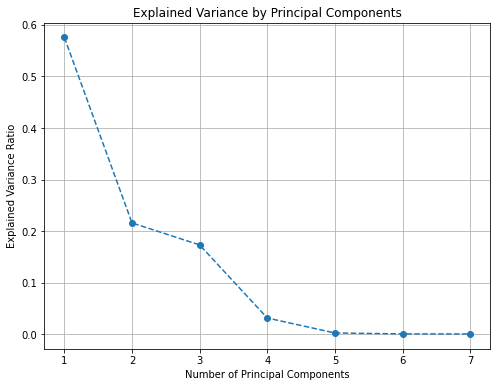

In [34]:
# Apply PCA
pca = PCA(n_components=len(feature_cols))
pca.fit(df[feature_cols])

# Get the explained variance ratios
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance ratios
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

In [35]:
# Based on above cell PCA score.
threshold = 2

data = df[feature_cols]

# Apply variance thresholding
selector = VarianceThreshold(threshold=threshold)
selector.fit(data)

# Get the support mask
mask = selector.get_support()

# Get selected feature names
selected_features = data.columns[mask]
print("Selected Features:", selected_features)
feature_cols = selected_features

Selected Features: Index(['accurate_description', 'communication', 'shipping_speed',
       'reasonable_shipping_cost', 'item_approx_price', 'feedback_pr'],
      dtype='object')


---
> Explnation of this code:
> ``` python
> sum(np.min(cdist(scaled_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / scaled_data.shape[0]
> ```

`cdist(scaled_data, kmeans.cluster_centers_, 'euclidean')`: This calculates the Euclidean distance between the data points (scaled) and the cluster centers obtained by the KMeans algorithm.

`np.min(..., axis=1)`: This finds the minimum distance for each data point to its nearest cluster center.

`sum(...)` is used to sum up all the minimum distances.

Finally, the sum is divided by the total number of data points (rows) to compute the average, which is the inertia.

/home/jaydeep/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaydeep/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaydeep/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaydeep/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

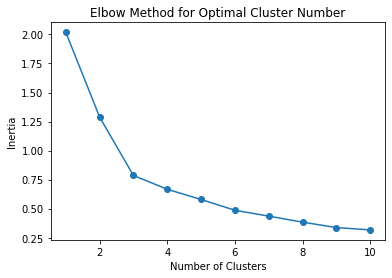

In [36]:
data = df[feature_cols]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Determine the optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(sum(np.min(cdist(scaled_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / scaled_data.shape[0])

# Plot the Elbow method results
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()


##### Selecting the Optimal Number of Clusters Using the Elbow Method

- Upon plotting the Elbow method graph, we observed a distinct point where the inertia, representing the within-cluster sum of squared distances to the nearest cluster center, started decreasing at a slower rate. This particular point is commonly referred to as the "elbow" point in the plot, indicating the optimal number of clusters for the dataset.

- After careful analysis of the Elbow method graph, we determined that the inertia began to decrease more slowly after the point representing **3 clusters**. Therefore, we **selected 3 clusters** as the optimal number for our K-Means clustering model.

- For this dataset we will use 2 Clustring algorithms `K-Means Clustering` and `AgglomerativeClustring`
- Why we consider using **AgglomerativeClustring**?
    - **Hierarchical Structure**
    - **No Need to Prespecify the Number of Clusters**: Unlike K-Means, Agglomerative Clustering does not require you to specify the number of clusters beforehand. It can automatically determine the number of clusters based on the structure of the data.



#### K-Means Clustering


In [37]:

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# Analyze the results
print(df['kmeans_cluster'].value_counts())


/home/jaydeep/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


kmeans_cluster
1    1259
0     802
2     290
Name: count, dtype: int64


#### AgglomerativeClustering
- Here we did not specify and cluster number because this algorithm can find ideal cluster number by itself.

In [38]:

# Apply Agglomerative Clustering
agglomerative_cluster = AgglomerativeClustering(affinity='euclidean', linkage='ward')
clusters = agglomerative_cluster.fit_predict(scaled_data)

# Add the cluster labels back to the DataFrame
df['agglomerative_cluster'] = clusters

# Analyze the results
print(df['agglomerative_cluster'].value_counts())

agglomerative_cluster
0    2061
1     290
Name: count, dtype: int64


/home/jaydeep/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


##### Visual comparison of these two clustering algorithms

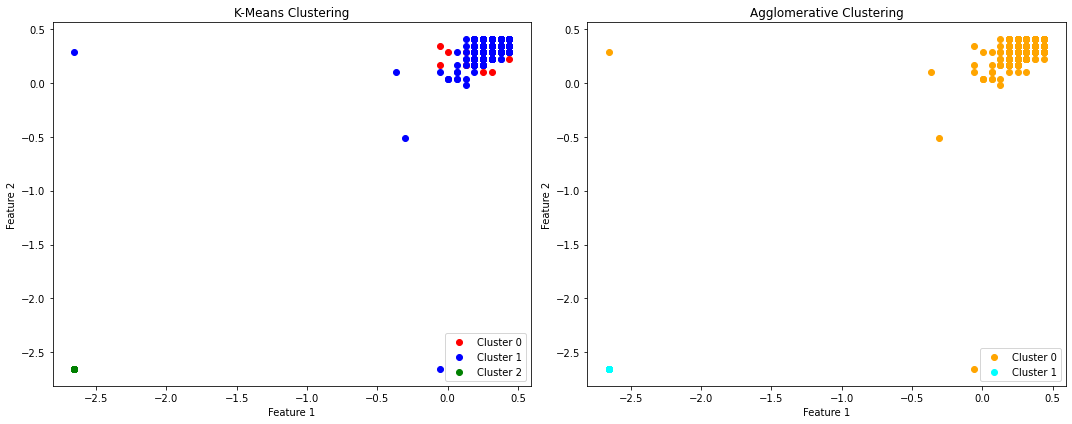

In [39]:
# Assign fixed colors for the clusters
kmeans_colors = ['red', 'blue', 'green']
agglomerative_colors = ['orange', 'cyan']  # Assuming 2 clusters in Agglomerative Clustering

# Visualize the clusters side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# K-Means Clustering plot
for i in range(3):  # Assuming 4 clusters in K-Means Clustering
    axes[0].scatter(scaled_data[df.kmeans_cluster == i, 0], scaled_data[df.kmeans_cluster == i, 1], color=kmeans_colors[i], label=f'Cluster {i}')
axes[0].set_title('K-Means Clustering')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()

# Agglomerative Clustering plot
for i in range(2):  # Assuming 2 clusters in Agglomerative Clustering
    axes[1].scatter(scaled_data[df.agglomerative_cluster == i, 0], scaled_data[df.agglomerative_cluster == i, 1], color=agglomerative_colors[i], label=f'Cluster {i}')
axes[1].set_title('Agglomerative Clustering')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()

plt.tight_layout()
plt.show()


### Clustering Analysis Comparison

Upon conducting a visual analysis of the clustering results, the following key observations emerged:

#### K-means Clustering Plot

- In the K-means Clustering plot, the data points are segregated into three distinctive clusters.
- Notably, Cluster 0 and Cluster 1 exhibit an overlapping pattern in the top-left region of the chart.
- Conversely, Cluster 2 is visibly positioned in the bottom-right corner, appearing separate from the other clusters.

#### Agglomerative Clustering Plot

- The Agglomerative Clustering plot, in contrast, showcases a different perspective.
- The data points are categorized into only two clusters.
- Notably, the data points that were perceived as distinct clusters (0 and 1) in K-means have been merged into a single cluster in Agglomerative Clustering.
- Additionally, Cluster 1 in Agglomerative Clustering aligns with the location of K-means Cluster 2, situated in the bottom-right quadrant of the chart.

This discrepancy underscores the nuanced variations in the clustering approaches employed by K-means and Agglomerative Clustering. 
It highlights the impact of distinct methodologies on cluster identification and formation.


### Comparison of Evaluation Metrics for Clustering Algorithms

In [40]:
# Calculate the evaluation metrics
kmeans_silhouette_score = silhouette_score(scaled_data, df.kmeans_cluster)
agglomerative_silhouette_score = silhouette_score(scaled_data, df.agglomerative_cluster)

kmeans_db_index = davies_bouldin_score(scaled_data, df.kmeans_cluster)
agglomerative_db_index = davies_bouldin_score(scaled_data, df.agglomerative_cluster)

kmeans_calinski_harabasz_index = calinski_harabasz_score(scaled_data, df.kmeans_cluster)
agglomerative_calinski_harabasz_index = calinski_harabasz_score(scaled_data, df.agglomerative_cluster)

scores = {
    'K-Means': {'Silhouette Score': kmeans_silhouette_score, 'Davies-Bouldin Index': kmeans_db_index, 'Calinski-Harabasz Index': kmeans_calinski_harabasz_index},
    'Agglomerative': {'Silhouette Score': agglomerative_silhouette_score, 'Davies-Bouldin Index': agglomerative_db_index, 'Calinski-Harabasz Index': agglomerative_calinski_harabasz_index}
}

# Print the results
print(f"K-Means Silhouette Score: {kmeans_silhouette_score}")
print(f"Agglomerative Silhouette Score: {agglomerative_silhouette_score}")
print(f"K-Means Davies-Bouldin Index: {kmeans_db_index}")
print(f"Agglomerative Davies-Bouldin Index: {agglomerative_db_index}")
print(f"K-Means Calinski-Harabasz Index: {kmeans_calinski_harabasz_index}")
print(f"Agglomerative Calinski-Harabasz Index: {agglomerative_calinski_harabasz_index}")


K-Means Silhouette Score: 0.588629128758255
Agglomerative Silhouette Score: 0.7385744620334941
K-Means Davies-Bouldin Index: 0.5683735822545983
Agglomerative Davies-Bouldin Index: 0.420512365398228
K-Means Calinski-Harabasz Index: 5466.170046404734
Agglomerative Calinski-Harabasz Index: 5022.214941110025


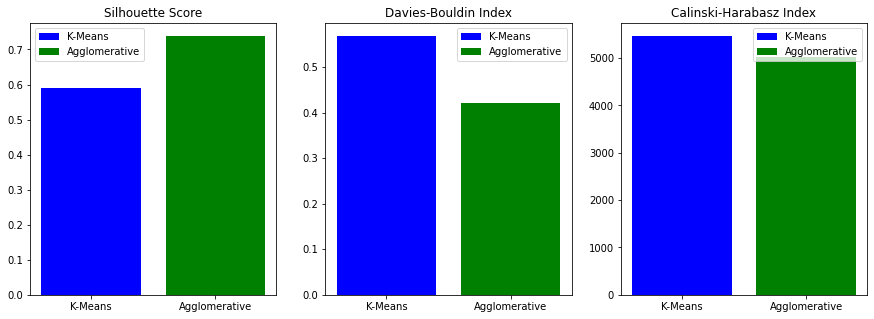

In [41]:
# Define the algorithms and metrics to plot
algorithms = ['K-Means', 'Agglomerative']
metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']

# Define the colors for each algorithm
colors = {'K-Means': 'blue', 'Agglomerative': 'green'}

# Create the bar chart
fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize=(15, 5))
for i, metric in enumerate(metrics):
    for j, algorithm in enumerate(algorithms):
        score = scores[algorithm][metric]
        axs[i].bar(j, score, color=colors[algorithm], label=algorithm)
    axs[i].set_title(metric)
    axs[i].set_xticks(range(len(algorithms)))
    axs[i].set_xticklabels(algorithms)
    axs[i].legend()

plt.show()

### Evaluation of Clustering Algorithms

After conducting an in-depth evaluation using various metrics, the following insights were obtained:

### Silhouette Score

- K-Means: 0.589
- Agglomerative: 0.739

The **Agglomerative Clustering** method demonstrated a notably **higher Score**, signifying better-defined clusters with increased intra-cluster similarity and decreased inter-cluster dissimilarity.

### Davies-Bouldin Index

- K-Means: 0.568
- Agglomerative: 0.421

The **Agglomerative Clustering** algorithm yielded a significantly lower Davies-Bouldin Index, indicating improved clustering performance and enhanced separation between clusters.

### Calinski-Harabasz Index

- K-Means: 5466.17
- Agglomerative: 5022.21

While both algorithms produced high Calinski-Harabasz Index values, the **Agglomerative Clustering** method exhibited a slightly lower value, suggesting the presence of well-defined, dense, and well-separated clusters.


-----
## Step - 9
(Bonus mark): if your input includes txt data, please apply proper NLP techniques (data cleaning, stop word/punctuation removal, tokenizing, stemming/lemmatizing etc) and bonus mark might be granted.

In [42]:
# Import necessary libraries
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [43]:
# Function for cleaning and preprocessing text data
def text_cleaning(comments):
    """
    Perform text cleaning and preprocessing on the given comments.

    Args:
    comments (str): Input string of comments.

    Returns:
    str: Cleaned and preprocessed text data.
    """
    lemmatized_tokens = []
    for comment in comments.split('&'):
        # Tokenize the text and convert to lowercase
        text_splitting = word_tokenize(comment.lower())
        # Filter out English stopwords
        filtered_tokens = [token for token in text_splitting if token not in stopwords.words('english')]
        lemmatizer = WordNetLemmatizer()
        # Lemmatize the tokens to their base form
        lemmatized_tokens.extend([lemmatizer.lemmatize(token) for token in filtered_tokens])
    # Join the lemmatized tokens back into a cleaned string
    return ' '.join(lemmatized_tokens)


# Function to calculate a score based on a given row's 'pos' value
def calculate_score(row):
    """
    Calculate a score based on the 'pos' value in the row.

    Args:
    row: A row from a DataFrame.

    Returns:
    int: 1 if 'pos' is greater than 0, otherwise 0.
    """
    return 1 if row.pos > 0 else 0


# Function to perform sentiment analysis on comments using VADER
def sentiment_analysis(comments):
    """
    Perform sentiment analysis using VADER on the provided comments.

    Args:
    comments (dict): A dictionary where keys are seller names and values are cleaned comment strings.

    Returns:
    list: A list of dictionaries containing sentiment analysis results for each seller.
    """
    analyzer = SentimentIntensityAnalyzer()

    if not isinstance(comments, dict):
        print("Cannot print sentiment analysis because the input is not a dictionary.")
        return
        
    data = []
    for seller_name, comment_tokens in comments.items():
        # Perform sentiment analysis using VADER
        sentiment_on_text = analyzer.polarity_scores(comment_tokens)
        sentiment_on_text['seller_name'] = seller_name
        data.append(sentiment_on_text)
    return data
    
    
# Function to initiate the sentiment analysis process
def initiate_analysis(df):
    """
    Initiate the sentiment analysis process for the DataFrame.

    Args:
    df (pandas.DataFrame): Input DataFrame containing the necessary data.

    Returns:
    list: A list of dictionaries containing the sentiment analysis results.
    """
    comments = {}
    for _, row in df.iterrows():
        # Clean and preprocess comments for each seller
        comments[row.seller_name] = text_cleaning(row.comment)
    # Perform sentiment analysis on the cleaned comments
    data = sentiment_analysis(comments)
    return data


In [44]:
analyze_df = pd.DataFrame(initiate_analysis(df))
analyze_df.head()

,neg,neu,pos,compound,seller_name
0,0.355,0.482,0.162,-0.5267,health-solution-prime
1,0.000,0.331,0.669,0.9531,Richisabatin_0
2,0.000,0.222,0.778,0.8885,Nature Supplements Store
3,0.000,0.305,0.695,0.8442,Nutriment Boutique
4,0.000,0.000,0.000,0.0000,alg_energy_nutra


In [45]:
# Calculate score for each row in the DataFrame using the 'calculate_score' function
analyze_df['score'] = analyze_df.apply(calculate_score, axis=1)


In [46]:
analyze_df.head()

,neg,neu,pos,compound,seller_name,score
0,0.355,0.482,0.162,-0.5267,health-solution-prime,1
1,0.000,0.331,0.669,0.9531,Richisabatin_0,1
2,0.000,0.222,0.778,0.8885,Nature Supplements Store,1
3,0.000,0.305,0.695,0.8442,Nutriment Boutique,1
4,0.000,0.000,0.000,0.0000,alg_energy_nutra,0


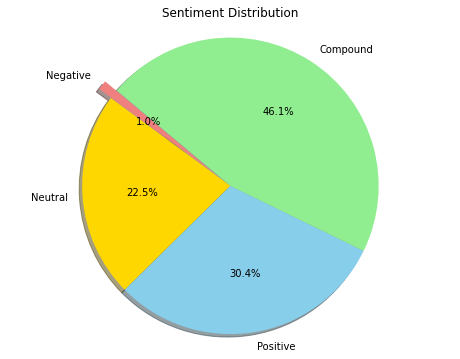

In [47]:


# Data preparation
labels = ['Negative', 'Neutral', 'Positive', 'Compound']
sizes = [analyze_df['neg'].mean(), analyze_df['neu'].mean(), analyze_df['pos'].mean(), analyze_df['compound'].mean()]
colors = ['lightcoral', 'gold', 'skyblue', 'lightgreen']
explode = (0.1, 0, 0, 0)  # Explode the 1st slice

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Distribution')
plt.show()


### Sentiment Analysis

- **Compound**: 46.1%
- **Positive**: 30.4%
- **Neutral**: 22.5%
- **Negative**: 1.0%

Based on the sentiment distribution, it's evident that a significant portion of the sentiments falls under the **Compound** category, accounting for 46.1%. This suggests a mixture of both positive and negative sentiments within the dataset.

**Positive** sentiments make up 30.4% of the sentiments, indicating an overall positive trend in the expressions. 

**Neutral** sentiments account for 22.5% of the dataset, showing a substantial presence of sentiments that are neither explicitly positive nor negative.

On the other hand, **Negative** sentiments are the least prevalent, making up only 1.0% of the overall sentiment distribution. This suggests that negative sentiments are relatively rare in the dataset.

Overall we can say that the tone of these comments received on ebay for seller was mostly either positive or compound. 

-----
## Conclusion

In this study, a comprehensive analysis of the dataset was conducted to identify meaningful clusters using various clustering algorithms. Key steps and methodologies included:

- Data preprocessing, handling missing values, and managing special characters and emojis.
- Feature engineering techniques like data transformation and extraction of essential information.
- Utilization of the Elbow Point Method and Silhouette Analysis for cluster determination.
- Evaluation of K-means and Agglomerative Clustering performance using various metrics.
- Visualization techniques for cluster comparison and pattern identification.
- Feature selection methods, such as Variance Thresholding.

The findings revealed that the **Agglomerative Clustering** algorithm **outperformed K-means Clustering** in terms of the evaluated metrics. It demonstrated distinct, well-defined clusters with enhanced intra-cluster similarity and inter-cluster dissimilarity.

Overall, the methodologies applied in this study provided valuable insights and paved the way for deeper analysis and informed decision-making processes.

> **Note:**
> This Evaluation metric was found online, and then we used it in the practice here. And whatever conclusion we have come up with here is also upon the information we gather for this matrics over the internet.